# 为了防止Colab掉线，在控制台输入：
```
setInterval(()=>{
	if(Array.from(document.getElementById("connect").children[0].children[2].innerHTML).splice(3,4).toString() === '重,新,连,接'){
		document.getElementById("connect").children[0].children[2].click()
	}
},1000)
```

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.image as imgplt
import os
import os.path
os.chdir('/content/gdrive/My Drive/Colab')

## Sanity Check:检查label是否匹配

In [8]:
labels = pd.read_csv('origin_annotate.csv')
labels.head()
tmp_label = labels['synthesis_label'].to_list()
ground_label = tuple(eval(x) for x in tmp_label)
labels.head()

,Unnamed: 0,circle_origin,big_arrow_end,small_arrow_end,synthesis_label
0,1000L-200_s-10.jpg,"(587, 819)","(496, 1117)","(411, 949)","(587, 819, 496, 1117, 411, 949)"
1,1001L-200_s-10.jpg,"(587, 819)","(500, 1119)","(412, 950)","(587, 819, 500, 1119, 412, 950)"
2,100L-250_s-11.jpg,"(587, 819)","(529, 1126)","(419, 958)","(587, 819, 529, 1126, 419, 958)"
3,101L-250_s-11.jpg,"(587, 819)","(533, 1126)","(420, 960)","(587, 819, 533, 1126, 420, 960)"
4,102L-250_s-11.jpg,"(587, 819)","(538, 1127)","(421, 961)","(587, 819, 538, 1127, 421, 961)"


(1088, 1920, 3)

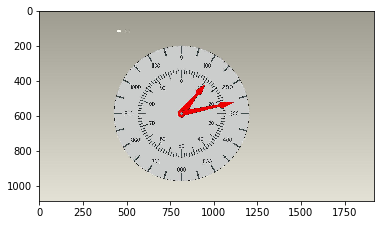

In [9]:
test_data_dir = r'/content/gdrive/My Drive/Colab/pic/labeled_data'
test_pic_name = '100L-250_s-11.jpg'
test_pic = os.path.join(test_data_dir,test_pic_name)
im = imgplt.imread(test_pic)
plt.imshow(im)
im.shape

## 读取label文件，转换为数据集的目标数据

In [0]:
working_dir = r'pic/labeled_data'
if(not os.path.exists(working_dir)):
    print('路径不存在')
pic = os.path.join(working_dir,'1001L-200_s-10.jpg')
im = imgplt.imread(pic)
WIDTH = im.shape[0]
LENGTH = im.shape[1]

In [11]:
flow_dataframe = pd.DataFrame({
    'name':labels['Unnamed: 0'],
    'circle_origin_v':tuple(x[0]/WIDTH for x in ground_label),
    'circle_origin_h':tuple(x[1]/LENGTH for x in ground_label),
    'big_arrow_end_v':tuple(x[2]/WIDTH for x in ground_label),
    'big_arrow_end_h':tuple(x[3]/LENGTH for x in ground_label),
    'small_arrow_end_v':tuple(x[4]/WIDTH for x in ground_label),
    'small_arrow_end_h':tuple(x[5]/LENGTH for x in ground_label),
})
flow_dataframe.head()
flow_dataframe.loc[flow_dataframe.loc[:,'name'] == test_pic_name].loc[:,:]

,name,circle_origin_v,circle_origin_h,big_arrow_end_v,big_arrow_end_h,small_arrow_end_v,small_arrow_end_h
2,100L-250_s-11.jpg,0.539522,0.426563,0.486213,0.586458,0.38511,0.498958


## 读取数据集

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#归一化数据
train_datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.1)
#直接从文件夹中读取图片数据
train_batch = 100
test_batch = 100
image_size = (500,500)
train_generator = train_datagen.flow_from_dataframe(
    dataframe = flow_dataframe,
    directory = working_dir, # 文件目录
    x_col = 'name',
    subset='training',
    y_col = np.array(['circle_origin_v','circle_origin_h','big_arrow_end_v','big_arrow_end_h','small_arrow_end_v','small_arrow_end_h']),
    target_size= image_size,  # 希望统一化的像素
    batch_size=train_batch,     #Batch大小
    shuffle = True,
    class_mode= 'raw',#'multi_output',
    seed = 42) 

validation_generator = train_datagen.flow_from_dataframe(
    dataframe = flow_dataframe,
    directory = working_dir, # 文件目录
    x_col = 'name',
    subset='validation',
    y_col = np.array(['circle_origin_v','circle_origin_h','big_arrow_end_v','big_arrow_end_h','small_arrow_end_v','small_arrow_end_h']),
    target_size=image_size,  # 希望统一化的像素
    batch_size=test_batch,     #Batch大小
    shuffle = True,
    class_mode= 'raw',#'multi_output',
    seed = 42) 

Found 901 validated image filenames.
Found 100 validated image filenames.


## 定义模型

In [13]:
TRANSFER_MODEL=tf.keras.applications.VGG19(input_shape=(image_size[0],image_size[1],3),include_top=False,weights='imagenet')
#TRANSFER_MODEL=tf.keras.applications.ResNet101V2(input_shape=(image_size[0],image_size[1],3),include_top=False,weights='imagenet')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
80142336/80134624 [==============================] - 1s 0us/step


In [0]:
def create_model():
  model = tf.keras.models.Sequential()
  model.add(TRANSFER_MODEL)
  TRANSFER_MODEL.trainable=False
  model.add(tf.keras.layers.MaxPool2D((2,2)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dropout(0.25))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(32, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(6, activation='sigmoid'))
  return model

In [0]:
model = create_model()
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-1),
  loss='mean_squared_error',
  metrics=['MeanAbsoluteError'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 15, 15, 512)       20024384  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 32)                802848    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

#### Create paths to save model's weights

In [0]:
file_path = r'model_checkpoints/'
model_save_name = r'weights.{epoch:02d}-{val_loss:.2f}.hdf5'
if(not os.path.exists(file_path)):
    print('路径不存在,已自动创建。')
    os.mkdir(file_path)
model_save_full_dir = os.path.join(file_path,model_save_name)

save_model = tf.keras.callbacks.ModelCheckpoint(filepath=model_save_full_dir,save_best_only=True,save_weights_only=True)

#### Train the model

In [0]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=3, min_lr=1e-9,verbose=1)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.labels.shape[0]//train_batch,
    validation_data = validation_generator,
    validation_steps = validation_generator.labels.shape[0]//test_batch,
    validation_freq = 1,
    epochs = 30,
    verbose=2,
    callbacks=[reduce_lr,save_model])#tf.keras.callbacks.EarlyStopping()

Epoch 1/30
Epoch 1/30
9/9 - 167s - loss: 0.0250 - mean_absolute_error: 0.1168 - val_loss: 0.0352 - val_mean_absolute_error: 0.1606
Epoch 2/30
Epoch 1/30
9/9 - 161s - loss: 0.0147 - mean_absolute_error: 0.0906 - val_loss: 0.0127 - val_mean_absolute_error: 0.0803
Epoch 3/30
Epoch 1/30
9/9 - 177s - loss: 0.0094 - mean_absolute_error: 0.0714 - val_loss: 0.0165 - val_mean_absolute_error: 0.1024
Epoch 4/30
Epoch 1/30
9/9 - 163s - loss: 0.0106 - mean_absolute_error: 0.0732 - val_loss: 0.0314 - val_mean_absolute_error: 0.1307
Epoch 5/30
Epoch 1/30
9/9 - 159s - loss: 0.0115 - mean_absolute_error: 0.0751 - val_loss: 0.0105 - val_mean_absolute_error: 0.0788
Epoch 6/30
Epoch 1/30
9/9 - 164s - loss: 0.0100 - mean_absolute_error: 0.0692 - val_loss: 0.0143 - val_mean_absolute_error: 0.0987
Epoch 7/30
Epoch 1/30
9/9 - 160s - loss: 0.0096 - mean_absolute_error: 0.0693 - val_loss: 0.0119 - val_mean_absolute_error: 0.0930
Epoch 8/30
Epoch 1/30

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0

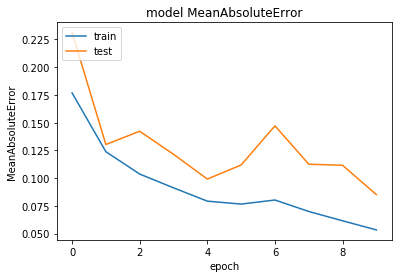

In [0]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MeanAbsoluteError')
plt.ylabel('MeanAbsoluteError')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
weights_name = os.listdir(file_path)[-1]

model.load_weights(filepath=os.path.join(file_path,weights_name))
print('已读取weights文件:\t',weights_name)

已读取weights文件:	 weights.65-0.01.hdf5


### Plot predictions

In [0]:
def plot_dot(image,label,scale_factor,title=''):
  label_location = [None]*len(label)
  for cnt in range(len(label)):
    if(cnt%2 == 0):#index 0\2\4 对应纵坐标
      label_location[cnt] = int(label[cnt] * scale_factor[0])
    else:
      label_location[cnt] = int(label[cnt] * scale_factor[1])
  plt.imshow(image)
  plt.title(title)
  plt.scatter(label_location[1],label_location[0],c='m')# 画圆心
  plt.scatter(label_location[3],label_location[2],c='g')# 画大指针
  plt.scatter(label_location[5],label_location[4],c='b')# 画小指针

#### Plot validation data's predictions

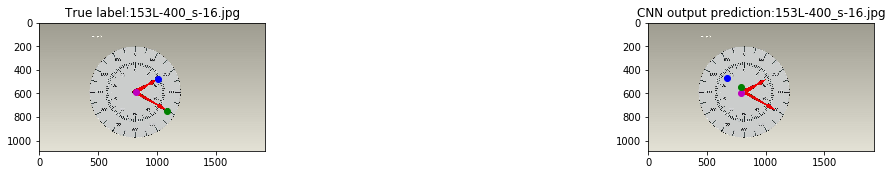

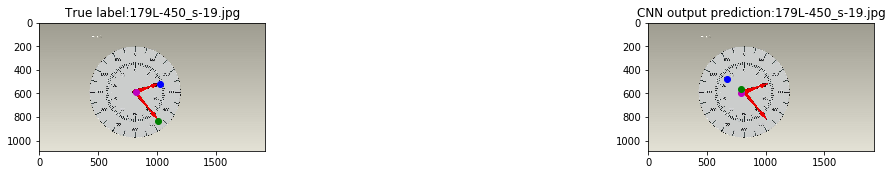

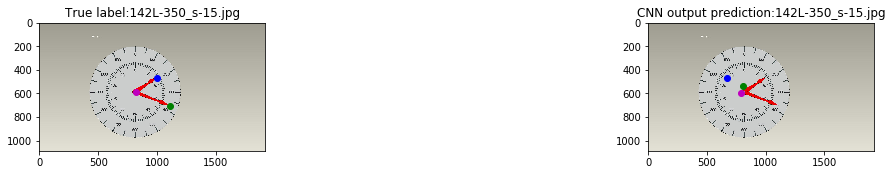

In [0]:
test_data_dir = r'/content/gdrive/My Drive/Colab/pic/labeled_data'
# Randomly pick N pictures for predicting
N = 3
np.random.seed()
random_index = np.random.randint(1,validation_generator.samples,size=(N,))
for val_sample in range(N):
  test_pic_name = validation_generator.filenames[random_index[val_sample]]
  test_pic = os.path.join(test_data_dir,test_pic_name)
  im = imgplt.imread(test_pic)
  tf_im = tf.keras.preprocessing.image.load_img(test_pic,color_mode='rgb',target_size=image_size)
  tf_im = tf.keras.preprocessing.image.img_to_array(tf_im,data_format=None,dtype=None)/255.
  plt.figure(figsize=(20,8))
  plt.subplot(N,2,2*(val_sample+1)-1)
  ground_truth_label = labels.loc[labels.loc[:,'Unnamed: 0'] == test_pic_name].loc[:,'synthesis_label']
  ground_truth_label = eval(list(ground_truth_label)[0])
  plot_dot(im,ground_truth_label,[1,1],'True label:'+test_pic_name)
  plt.subplot(N,2,2*(val_sample+1))
  output = model.predict(np.array([tf_im]))[0]
  plot_dot(im,output,[WIDTH,LENGTH],'CNN output prediction:'+test_pic_name)